## Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

## Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated bythese systems make them attractive for the research. Opposed to other transport services such as bus or subway, the durationof travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

    - instant: record index
    - dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,Input
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.nn import relu,leaky_relu

In [2]:
bike_data = pd.read_csv('hour.csv')

In [3]:
bike_data.head(5)

,instant,dateday,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,feelingTemp,humidity,windspeed,casual,registered,count
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01-01-2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01-01-2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_data.dtypes

instant          int64
dateday         object
season           int64
year             int64
month            int64
hour             int64
holiday          int64
weekday          int64
workingday       int64
weathersit       int64
temp           float64
feelingTemp    float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [5]:
# Converting dateday into datetime
bike_data['dateday'] = bike_data['dateday'].apply(lambda x: datetime.strptime(x,'%d-%m-%Y').date())


In [6]:
# Checking for null values
bike_data.isnull().sum()

# As we can see, there are no values in the dataset.

instant        0
dateday        0
season         0
year           0
month          0
hour           0
holiday        0
weekday        0
workingday     0
weathersit     0
temp           0
feelingTemp    0
humidity       0
windspeed      0
casual         0
registered     0
count          0
dtype: int64

In [7]:
print("Number of instances in the dataset : ",len(bike_data))
print("Number of unique recors in instant feature : ",len(bike_data['instant'].unique()))

# We can see that the 'instant' feature is an unique identifier attribute which does not provide any importance in the prediction
# Hence, we drop the 'instant' feature from the dataset.

Number of instances in the dataset :  17379
Number of unique recors in instant feature :  17379


In [8]:
# Dropping the instant feature
bike_data.drop(columns=['instant'],axis=1,inplace=True)

In [175]:
# bike_data.head()

In [9]:
date1 = '15-01-2011' 
conv_date = datetime.strptime(date1,'%d-%m-%Y').date()
print(conv_date.day)

15


In [10]:
# Since this is a regression problem where we are predicting the number of vehicles rented on an hourly basis, 'Dateday' attribute
# does not add much importance in the prediction.
# However, we can extract addditional features such as day and quarter from the Dateday feature. Hence we extract these additional features 
# before dropping the dateday column

bike_data['date'] = bike_data['dateday'].apply(lambda x: x.day)

# We do not extract 'quarter' from the date as we already have month and having both will still provide the same information.

In [11]:
# Dropping the 'dateday' feature
bike_data.drop(columns=['dateday'], axis=1, inplace=True)

In [12]:
bike_data.head(5)

,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,feelingTemp,humidity,windspeed,casual,registered,count,date
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [13]:
# Removing features
# date - Since we are predicting the number of rentals per hour, we remove date as it does not add importance.
# year - as we are predicting the 'count' by hour of the day, year does not add importance
# weekday - weekday provides information about what day of the week it is. Sincle bike rentals would differ based on weekday 
#            and weekend, this information is required. However, we have 'holiday' and 'workingday' that tells us if it was
#            a working day or a holiday. Hence we drop 'weekday' feature as we have holiday and workingday that provide similar
#            information.
# casual and registeres - We drop these two features as we have the label 'count' that is the sum of these two features that provide
#                         the total number of bookings made on that particular day

bike_data.drop(columns=['year','weekday','casual','registered','date'], axis=1, inplace=True)


In [14]:
# Reordering the columns
bike_data = bike_data[['season','month','hour','holiday','workingday','temp','feelingTemp','humidity','windspeed','count']]

In [15]:
bike_data.head(5)
# We do not performing scaling as the categorical variables such as the season, date, month, etc., holds specific information about each group.
# Numerical variables such as temp, feelingTemp, humidity and windspeed are normalised, hence we keep it as it is.

,season,month,hour,holiday,workingday,temp,feelingTemp,humidity,windspeed,count
0,1,1,0,0,0,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,0,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,0,0.22,0.2727,0.80,0.0,32
3,1,1,3,0,0,0.24,0.2879,0.75,0.0,13
4,1,1,4,0,0,0.24,0.2879,0.75,0.0,1


In [16]:
# Since this is a regression problem, more accurate predictions can be obtained by reducing the categorical variables and
# creating dummy variables for the categories
print(bike_data['season'].unique())
# print(bike_data['date'].unique())
print(bike_data['month'].unique())
print(bike_data['hour'].unique())
print(bike_data['holiday'].unique())
print(bike_data['workingday'].unique())

[1 2 3 4]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[0 1]
[0 1]


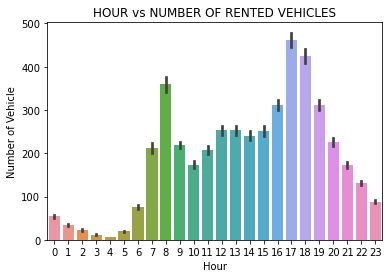

In [17]:
# We plot hour vs count to check the number of vehicles rented based on the hour and to discretize the hour attribute
# based on the graph

sns.barplot(x=bike_data['hour'],y=bike_data['count'])
plt.title("HOUR vs NUMBER OF RENTED VEHICLES")
plt.xlabel("Hour")
plt.ylabel("Number of Vehicle")
plt.show()


In [18]:
# Looking at the above graph,We discretize 'hour' feature into
# Morning(0) - 5-11
# Afternnon(1)- 12- 16
# Evening(2)- 17-21
# Night(3) - 22-4

def convert_hour(hour):
    if hour in range(5,12):
        return 0
    elif hour in range(12,17):
        return 1
    elif hour in range(17,22):
        return 2
    else:
        return 3

In [19]:
# Replacing the 'hour' feature based on the above criteria
bike_data['hour'] = bike_data['hour'].apply(lambda x: convert_hour(x))

In [20]:
bike_data['hour'].unique()
# bike_data.head(3)

array([3, 0, 1, 2], dtype=int64)

In [21]:
# Discretizing the 'month' feature
# We descretize the 'month' feature into 4 groups
# Q1(0):1-3, Q2(1):4-6, Q3(2):7-9, Q4(3):10-12

def get_quarter(month):
    if month in range(1,4):
        return 0
    elif month in range(4,7):
        return 1
    elif month in range(7,10):
        return 2
    else:
        return 3


In [22]:
# Converting 'month' based on the above criteria
bike_data['month'] = bike_data['month'].apply(lambda x: get_quarter(x))

In [23]:
bike_data['month'].unique()

array([0, 1, 2, 3], dtype=int64)

In [24]:
# All the other features are already discretized. Hence we create dummy variables for these categorical features
# season,month, and hour

month_dummies = pd.get_dummies(bike_data['month'],drop_first=True)
month_dummies.columns = ['Q2','Q3','Q4']
# print(month_dummies.head(4))

# 1:spring, 2:summer, 3:fall, 4:winter
season_dummies = pd.get_dummies(bike_data['season'],drop_first=True)
season_dummies.columns = ['summer','fall','winter']
# print(season_dummies.head(3))

hour_dummies = pd.get_dummies(bike_data['hour'],drop_first=True)
hour_dummies.columns = ['afternoon','evening','night']
# hour_dummies.head(3)

bike_data= pd.concat([bike_data,month_dummies,season_dummies,hour_dummies],axis=1)
bike_data.drop(columns=['season','hour','month'],axis=1,inplace = True)


In [25]:
print(len(bike_data))
print(len(hour_dummies))
print(len(month_dummies))
print(len(season_dummies))

17379
17379
17379
17379


In [26]:
# Arranging the features for better understanding
bike_data = bike_data[['summer','fall','winter','afternoon','evening','night','Q2','Q3','Q4','holiday','workingday','temp','feelingTemp','humidity','windspeed','count']]
bike_data.head(5)

,summer,fall,winter,afternoon,evening,night,Q2,Q3,Q4,holiday,workingday,temp,feelingTemp,humidity,windspeed,count
0,0,0,0,0,0,1,0,0,0,0,0,0.24,0.2879,0.81,0.0,16
1,0,0,0,0,0,1,0,0,0,0,0,0.22,0.2727,0.80,0.0,40
2,0,0,0,0,0,1,0,0,0,0,0,0.22,0.2727,0.80,0.0,32
3,0,0,0,0,0,1,0,0,0,0,0,0.24,0.2879,0.75,0.0,13
4,0,0,0,0,0,1,0,0,0,0,0,0.24,0.2879,0.75,0.0,1


In [27]:
# Separating the predictors and label variable
X = bike_data.drop('count',axis=1)
y = bike_data['count']

In [28]:
print(X.head(5))
print(y.head(5))

   summer  fall  winter  afternoon  evening  night  Q2  Q3  Q4  holiday  \
0       0     0       0          0        0      1   0   0   0        0   
1       0     0       0          0        0      1   0   0   0        0   
2       0     0       0          0        0      1   0   0   0        0   
3       0     0       0          0        0      1   0   0   0        0   
4       0     0       0          0        0      1   0   0   0        0   

   workingday  temp  feelingTemp  humidity  windspeed  
0           0  0.24       0.2879      0.81        0.0  
1           0  0.22       0.2727      0.80        0.0  
2           0  0.22       0.2727      0.80        0.0  
3           0  0.24       0.2879      0.75        0.0  
4           0  0.24       0.2879      0.75        0.0  
0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64


In [29]:
# Train test split
# We are considering 70% for training data and 30% for testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(12165, 15)
(5214, 15)
(12165,)
(5214,)


In [31]:
# The tensorflow package is built upon numpy ndarray and NN the models perform better when array is provided as in input
# Hence we convert the train and test data into arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [32]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(12165, 15)
(5214, 15)
(12165,)
(5214,)


In [91]:
# def build_tf_regression():
#     bike_model = Sequential()
#     bike_model.add(Input(shape=(10,)))
#     bike_model.add(Dense(20, activation ='relu'))
#     bike_model.add(Dropout(0.2))
#     bike_model.add(Dense(20, activation ='relu'))
#     bike_model.add(Dense(1,activation = 'relu'))
    
#     bike_model.compile(optimizer=Adam(),loss='mse', metrics=['mse','mae'])
    
#     return model

In [33]:
# Building the neural network architecture
# As the training data is already Flattened (1d), we do not performing Flatteing for this dataset
bike_model = Sequential()
bike_model.add(Input(shape=(15,)))
bike_model.add(Dense(32, activation ='relu'))
bike_model.add(Dropout(0.2))
bike_model.add(Dense(32, activation ='relu'))
bike_model.add(Dense(1,activation='relu'))

In [34]:
bike_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                512       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compiling the model
bike_model.compile(optimizer=Adam(),loss='mse', metrics=['mse','mae'])

In [36]:
# Fitting the model to the training data
history = bike_model.fit(X_train,y_train,batch_size=10,epochs=1000,validation_split=0.2)

Epoch 1/1000
974/974 [==============================] - 3s 4ms/step - loss: 33087.4023 - mse: 33087.4023 - mae: 130.1671 - val_loss: 20456.6953 - val_mse: 20456.6953 - val_mae: 104.0308
Epoch 2/1000
974/974 [==============================] - 3s 4ms/step - loss: 19660.8965 - mse: 19660.8965 - mae: 102.3730 - val_loss: 18758.7793 - val_mse: 18758.7793 - val_mae: 99.9119
Epoch 3/1000
974/974 [==============================] - 3s 3ms/step - loss: 18887.8086 - mse: 18887.8086 - mae: 98.8791 - val_loss: 18084.4512 - val_mse: 18084.4512 - val_mae: 96.8791
Epoch 4/1000
974/974 [==============================] - 3s 3ms/step - loss: 18355.8281 - mse: 18355.8281 - mae: 96.9180 - val_loss: 17632.1055 - val_mse: 17632.1055 - val_mae: 95.1313
Epoch 5/1000
974/974 [==============================] - 3s 3ms/step - loss: 17903.7031 - mse: 17903.7031 - mae: 95.3147 - val_loss: 17294.6934 - val_mse: 17294.6914 - val_mae: 92.3417
Epoch 6/1000
974/974 [==============================] - 3s 3ms/step - loss: 1

974/974 [==============================] - 3s 3ms/step - loss: 15378.4854 - mse: 15378.4854 - mae: 88.4020 - val_loss: 14288.6084 - val_mse: 14288.6084 - val_mae: 84.3879
Epoch 46/1000
974/974 [==============================] - 3s 3ms/step - loss: 15248.3457 - mse: 15248.3457 - mae: 88.1917 - val_loss: 14135.3770 - val_mse: 14135.3789 - val_mae: 84.7296
Epoch 47/1000
974/974 [==============================] - 3s 3ms/step - loss: 15344.2188 - mse: 15344.2188 - mae: 88.4509 - val_loss: 14210.7441 - val_mse: 14210.7441 - val_mae: 84.8148
Epoch 48/1000
974/974 [==============================] - 3s 3ms/step - loss: 15263.8516 - mse: 15263.8516 - mae: 88.1979 - val_loss: 14141.7637 - val_mse: 14141.7637 - val_mae: 84.8219
Epoch 49/1000
974/974 [==============================] - 2s 3ms/step - loss: 15385.7373 - mse: 15385.7373 - mae: 88.1837 - val_loss: 14180.7744 - val_mse: 14180.7744 - val_mae: 85.4038
Epoch 50/1000
974/974 [==============================] - 3s 3ms/step - loss: 15280.1465 -

974/974 [==============================] - 3s 3ms/step - loss: 15055.5625 - mse: 15055.5625 - mae: 87.0184 - val_loss: 13867.7637 - val_mse: 13867.7637 - val_mae: 84.1351
Epoch 90/1000
974/974 [==============================] - 3s 3ms/step - loss: 14993.0107 - mse: 14993.0107 - mae: 87.1224 - val_loss: 13900.5791 - val_mse: 13900.5791 - val_mae: 83.0203
Epoch 91/1000
974/974 [==============================] - 3s 3ms/step - loss: 14849.5684 - mse: 14849.5684 - mae: 86.7389 - val_loss: 13935.9814 - val_mse: 13935.9814 - val_mae: 83.1546
Epoch 92/1000
974/974 [==============================] - 3s 3ms/step - loss: 14933.8252 - mse: 14933.8252 - mae: 86.5497 - val_loss: 13898.5830 - val_mse: 13898.5830 - val_mae: 83.4003
Epoch 93/1000
974/974 [==============================] - 3s 3ms/step - loss: 14821.2988 - mse: 14821.2988 - mae: 86.2361 - val_loss: 13789.4795 - val_mse: 13789.4795 - val_mae: 82.9090
Epoch 94/1000
974/974 [==============================] - 3s 3ms/step - loss: 14836.5625 -

974/974 [==============================] - 3s 3ms/step - loss: 14419.6699 - mse: 14419.6699 - mae: 85.1957 - val_loss: 13531.0312 - val_mse: 13531.0312 - val_mae: 83.4589
Epoch 134/1000
974/974 [==============================] - 3s 3ms/step - loss: 14326.2373 - mse: 14326.2373 - mae: 84.9801 - val_loss: 13456.0859 - val_mse: 13456.0859 - val_mae: 82.0936
Epoch 135/1000
974/974 [==============================] - 3s 3ms/step - loss: 14426.5713 - mse: 14426.5713 - mae: 85.4404 - val_loss: 13513.8516 - val_mse: 13513.8506 - val_mae: 82.0089
Epoch 136/1000
974/974 [==============================] - 2s 3ms/step - loss: 14364.5244 - mse: 14364.5244 - mae: 84.8197 - val_loss: 13464.3428 - val_mse: 13464.3428 - val_mae: 82.3190
Epoch 137/1000
974/974 [==============================] - 3s 3ms/step - loss: 14282.1816 - mse: 14282.1797 - mae: 85.0195 - val_loss: 13459.4785 - val_mse: 13459.4785 - val_mae: 82.7724
Epoch 138/1000
974/974 [==============================] - 3s 3ms/step - loss: 14382.7

974/974 [==============================] - 3s 3ms/step - loss: 14037.7871 - mse: 14037.7871 - mae: 83.8533 - val_loss: 13415.0928 - val_mse: 13415.0928 - val_mae: 82.6425
Epoch 178/1000
974/974 [==============================] - 2s 3ms/step - loss: 14131.5625 - mse: 14131.5625 - mae: 84.1724 - val_loss: 13394.5947 - val_mse: 13394.5947 - val_mae: 83.1270
Epoch 179/1000
974/974 [==============================] - 3s 3ms/step - loss: 14218.5332 - mse: 14218.5332 - mae: 84.4710 - val_loss: 13330.6328 - val_mse: 13330.6348 - val_mae: 82.5350
Epoch 180/1000
974/974 [==============================] - 3s 3ms/step - loss: 13973.2051 - mse: 13973.2051 - mae: 83.8200 - val_loss: 13425.1777 - val_mse: 13425.1777 - val_mae: 82.2033
Epoch 181/1000
974/974 [==============================] - 3s 3ms/step - loss: 14115.4346 - mse: 14115.4346 - mae: 84.1213 - val_loss: 13452.6768 - val_mse: 13452.6768 - val_mae: 81.5585
Epoch 182/1000
974/974 [==============================] - 2s 2ms/step - loss: 14163.2

974/974 [==============================] - 2s 3ms/step - loss: 13854.3623 - mse: 13854.3623 - mae: 83.2608 - val_loss: 13117.0684 - val_mse: 13117.0684 - val_mae: 81.7895
Epoch 222/1000
974/974 [==============================] - 3s 3ms/step - loss: 13878.9199 - mse: 13878.9199 - mae: 83.3049 - val_loss: 13186.6777 - val_mse: 13186.6777 - val_mae: 81.6697
Epoch 223/1000
974/974 [==============================] - 3s 3ms/step - loss: 13744.6982 - mse: 13744.6982 - mae: 83.0355 - val_loss: 13141.4395 - val_mse: 13141.4395 - val_mae: 81.2035
Epoch 224/1000
974/974 [==============================] - 3s 3ms/step - loss: 13871.7715 - mse: 13871.7715 - mae: 83.4662 - val_loss: 13140.1436 - val_mse: 13140.1436 - val_mae: 82.4333
Epoch 225/1000
974/974 [==============================] - 3s 3ms/step - loss: 13774.5762 - mse: 13774.5762 - mae: 82.9875 - val_loss: 13177.2080 - val_mse: 13177.2080 - val_mae: 82.9320
Epoch 226/1000
974/974 [==============================] - 3s 3ms/step - loss: 13701.3

974/974 [==============================] - 3s 3ms/step - loss: 13608.5332 - mse: 13608.5332 - mae: 82.2737 - val_loss: 13209.3154 - val_mse: 13209.3164 - val_mae: 83.3746
Epoch 266/1000
974/974 [==============================] - 2s 3ms/step - loss: 13638.9043 - mse: 13638.9043 - mae: 82.5277 - val_loss: 13050.6465 - val_mse: 13050.6475 - val_mae: 81.2048
Epoch 267/1000
974/974 [==============================] - 2s 3ms/step - loss: 13555.3838 - mse: 13555.3838 - mae: 82.4348 - val_loss: 13072.0312 - val_mse: 13072.0312 - val_mae: 81.1213
Epoch 268/1000
974/974 [==============================] - 2s 2ms/step - loss: 13569.7373 - mse: 13569.7373 - mae: 82.3403 - val_loss: 13121.4873 - val_mse: 13121.4873 - val_mae: 81.8583
Epoch 269/1000
974/974 [==============================] - 3s 3ms/step - loss: 13452.1641 - mse: 13452.1641 - mae: 82.1125 - val_loss: 13075.7734 - val_mse: 13075.7734 - val_mae: 80.9711
Epoch 270/1000
974/974 [==============================] - 3s 3ms/step - loss: 13621.7

974/974 [==============================] - 3s 3ms/step - loss: 13613.6807 - mse: 13613.6807 - mae: 82.3758 - val_loss: 13003.1660 - val_mse: 13003.1660 - val_mae: 81.2579
Epoch 310/1000
974/974 [==============================] - 3s 3ms/step - loss: 13518.8857 - mse: 13518.8857 - mae: 82.4711 - val_loss: 13043.3691 - val_mse: 13043.3691 - val_mae: 80.1614
Epoch 311/1000
974/974 [==============================] - 3s 3ms/step - loss: 13403.2754 - mse: 13403.2754 - mae: 81.7758 - val_loss: 13015.0029 - val_mse: 13015.0029 - val_mae: 82.3694
Epoch 312/1000
974/974 [==============================] - 3s 3ms/step - loss: 13514.7646 - mse: 13514.7646 - mae: 82.4405 - val_loss: 12994.1514 - val_mse: 12994.1514 - val_mae: 81.5358
Epoch 313/1000
974/974 [==============================] - 3s 3ms/step - loss: 13559.9316 - mse: 13559.9316 - mae: 82.5788 - val_loss: 13041.8789 - val_mse: 13041.8789 - val_mae: 80.2469
Epoch 314/1000
974/974 [==============================] - 3s 3ms/step - loss: 13441.1

974/974 [==============================] - 2s 3ms/step - loss: 13433.5977 - mse: 13433.5977 - mae: 81.7224 - val_loss: 13081.2129 - val_mse: 13081.2129 - val_mae: 83.0106
Epoch 354/1000
974/974 [==============================] - 3s 3ms/step - loss: 13353.2959 - mse: 13353.2959 - mae: 81.6747 - val_loss: 12975.7021 - val_mse: 12975.7021 - val_mae: 81.0250
Epoch 355/1000
974/974 [==============================] - 3s 3ms/step - loss: 13454.1826 - mse: 13454.1826 - mae: 82.0017 - val_loss: 12981.5664 - val_mse: 12981.5664 - val_mae: 79.9260
Epoch 356/1000
974/974 [==============================] - 3s 3ms/step - loss: 13417.2539 - mse: 13417.2539 - mae: 81.8734 - val_loss: 12820.8398 - val_mse: 12820.8398 - val_mae: 80.6187
Epoch 357/1000
974/974 [==============================] - 3s 3ms/step - loss: 13275.5820 - mse: 13275.5820 - mae: 81.5892 - val_loss: 12994.5713 - val_mse: 12994.5713 - val_mae: 80.7574
Epoch 358/1000
974/974 [==============================] - 3s 3ms/step - loss: 13387.0

974/974 [==============================] - 3s 3ms/step - loss: 13225.9404 - mse: 13225.9404 - mae: 81.1964 - val_loss: 12915.3076 - val_mse: 12915.3076 - val_mae: 81.5655
Epoch 397/1000
974/974 [==============================] - 3s 3ms/step - loss: 13240.8594 - mse: 13240.8594 - mae: 81.4265 - val_loss: 12780.5869 - val_mse: 12780.5869 - val_mae: 81.3988
Epoch 398/1000
974/974 [==============================] - 3s 3ms/step - loss: 13268.4541 - mse: 13268.4541 - mae: 81.3284 - val_loss: 12872.2197 - val_mse: 12872.2197 - val_mae: 81.8363
Epoch 399/1000
974/974 [==============================] - 3s 3ms/step - loss: 13284.1104 - mse: 13284.1104 - mae: 81.3677 - val_loss: 12810.1318 - val_mse: 12810.1318 - val_mae: 80.6345
Epoch 400/1000
974/974 [==============================] - 2s 3ms/step - loss: 13247.3330 - mse: 13247.3330 - mae: 81.1314 - val_loss: 12977.0381 - val_mse: 12977.0381 - val_mae: 82.5209
Epoch 401/1000
974/974 [==============================] - 2s 3ms/step - loss: 13228.2

974/974 [==============================] - 2s 2ms/step - loss: 13124.7109 - mse: 13124.7109 - mae: 80.9779 - val_loss: 12959.3418 - val_mse: 12959.3418 - val_mae: 82.1710
Epoch 441/1000
974/974 [==============================] - 2s 3ms/step - loss: 13220.1113 - mse: 13220.1113 - mae: 81.2499 - val_loss: 12822.9639 - val_mse: 12822.9639 - val_mae: 79.7638
Epoch 442/1000
974/974 [==============================] - 2s 2ms/step - loss: 13223.0967 - mse: 13223.0967 - mae: 81.0631 - val_loss: 12764.0352 - val_mse: 12764.0352 - val_mae: 80.2696
Epoch 443/1000
974/974 [==============================] - 2s 2ms/step - loss: 13153.1514 - mse: 13153.1514 - mae: 81.0410 - val_loss: 12922.8096 - val_mse: 12922.8096 - val_mae: 81.2037
Epoch 444/1000
974/974 [==============================] - 2s 2ms/step - loss: 13207.5723 - mse: 13207.5723 - mae: 81.1330 - val_loss: 12840.3857 - val_mse: 12840.3838 - val_mae: 81.1537
Epoch 445/1000
974/974 [==============================] - 2s 2ms/step - loss: 13309.0

974/974 [==============================] - 2s 2ms/step - loss: 13056.1475 - mse: 13056.1475 - mae: 80.7231 - val_loss: 12915.8271 - val_mse: 12915.8271 - val_mae: 79.9686
Epoch 485/1000
974/974 [==============================] - 2s 2ms/step - loss: 13162.7432 - mse: 13162.7432 - mae: 80.9285 - val_loss: 12825.8193 - val_mse: 12825.8193 - val_mae: 80.6748
Epoch 486/1000
974/974 [==============================] - 2s 2ms/step - loss: 13047.8525 - mse: 13047.8525 - mae: 80.8044 - val_loss: 13060.3994 - val_mse: 13060.3975 - val_mae: 79.4389
Epoch 487/1000
974/974 [==============================] - 2s 2ms/step - loss: 13177.2354 - mse: 13177.2354 - mae: 80.6290 - val_loss: 12936.4492 - val_mse: 12936.4492 - val_mae: 81.1178
Epoch 488/1000
974/974 [==============================] - 2s 2ms/step - loss: 13154.3027 - mse: 13154.3027 - mae: 81.2422 - val_loss: 12710.0469 - val_mse: 12710.0469 - val_mae: 80.2400
Epoch 489/1000
974/974 [==============================] - 2s 2ms/step - loss: 13158.1

974/974 [==============================] - 2s 2ms/step - loss: 13065.6123 - mse: 13065.6123 - mae: 80.4402 - val_loss: 12767.1436 - val_mse: 12767.1436 - val_mae: 80.2395
Epoch 529/1000
974/974 [==============================] - 2s 2ms/step - loss: 13030.2441 - mse: 13030.2441 - mae: 80.5158 - val_loss: 12832.3828 - val_mse: 12832.3828 - val_mae: 80.5719
Epoch 530/1000
974/974 [==============================] - 2s 2ms/step - loss: 13037.8311 - mse: 13037.8311 - mae: 80.6335 - val_loss: 12843.0371 - val_mse: 12843.0371 - val_mae: 81.1955
Epoch 531/1000
974/974 [==============================] - 2s 2ms/step - loss: 13076.7168 - mse: 13076.7168 - mae: 80.5931 - val_loss: 12925.8438 - val_mse: 12925.8438 - val_mae: 80.9714
Epoch 532/1000
974/974 [==============================] - 2s 2ms/step - loss: 13024.7588 - mse: 13024.7588 - mae: 80.6196 - val_loss: 12805.3369 - val_mse: 12805.3369 - val_mae: 81.4099
Epoch 533/1000
974/974 [==============================] - 2s 2ms/step - loss: 13039.4

974/974 [==============================] - 2s 2ms/step - loss: 12988.9629 - mse: 12988.9629 - mae: 80.5122 - val_loss: 12847.7793 - val_mse: 12847.7793 - val_mae: 81.6495
Epoch 573/1000
974/974 [==============================] - 2s 2ms/step - loss: 12936.0957 - mse: 12936.0957 - mae: 80.4053 - val_loss: 12834.5205 - val_mse: 12834.5205 - val_mae: 80.7352
Epoch 574/1000
974/974 [==============================] - 2s 2ms/step - loss: 12939.8389 - mse: 12939.8389 - mae: 80.1978 - val_loss: 12816.7822 - val_mse: 12816.7822 - val_mae: 81.4191
Epoch 575/1000
974/974 [==============================] - 2s 2ms/step - loss: 13058.8604 - mse: 13058.8604 - mae: 80.3766 - val_loss: 12752.5049 - val_mse: 12752.5049 - val_mae: 80.1684
Epoch 576/1000
974/974 [==============================] - 2s 2ms/step - loss: 13101.2002 - mse: 13101.2002 - mae: 80.9185 - val_loss: 12760.9238 - val_mse: 12760.9238 - val_mae: 80.1017
Epoch 577/1000
974/974 [==============================] - 2s 2ms/step - loss: 12965.4

974/974 [==============================] - 2s 2ms/step - loss: 12981.8164 - mse: 12981.8164 - mae: 80.3793 - val_loss: 12861.3691 - val_mse: 12861.3691 - val_mae: 81.0292
Epoch 617/1000
974/974 [==============================] - 2s 2ms/step - loss: 12935.1348 - mse: 12935.1348 - mae: 80.5154 - val_loss: 12746.6143 - val_mse: 12746.6143 - val_mae: 79.9604
Epoch 618/1000
974/974 [==============================] - 2s 2ms/step - loss: 12910.8066 - mse: 12910.8066 - mae: 79.9372 - val_loss: 12825.3320 - val_mse: 12825.3320 - val_mae: 81.3941
Epoch 619/1000
974/974 [==============================] - 2s 2ms/step - loss: 12981.5078 - mse: 12981.5078 - mae: 80.3689 - val_loss: 12734.7207 - val_mse: 12734.7207 - val_mae: 80.4785
Epoch 620/1000
974/974 [==============================] - 2s 2ms/step - loss: 12950.4834 - mse: 12950.4834 - mae: 80.2872 - val_loss: 12822.1895 - val_mse: 12822.1895 - val_mae: 79.7279
Epoch 621/1000
974/974 [==============================] - 2s 2ms/step - loss: 13010.5

974/974 [==============================] - 2s 2ms/step - loss: 12970.9033 - mse: 12970.9033 - mae: 80.3122 - val_loss: 12938.1270 - val_mse: 12938.1270 - val_mae: 80.8324
Epoch 661/1000
974/974 [==============================] - 2s 2ms/step - loss: 13038.3555 - mse: 13038.3555 - mae: 80.6572 - val_loss: 12795.4189 - val_mse: 12795.4189 - val_mae: 80.1716
Epoch 662/1000
974/974 [==============================] - 2s 2ms/step - loss: 12890.0859 - mse: 12890.0859 - mae: 80.2700 - val_loss: 12855.8643 - val_mse: 12855.8643 - val_mae: 81.2472
Epoch 663/1000
974/974 [==============================] - 2s 2ms/step - loss: 12910.4287 - mse: 12910.4287 - mae: 80.2174 - val_loss: 12798.7686 - val_mse: 12798.7686 - val_mae: 79.3754
Epoch 664/1000
974/974 [==============================] - 2s 2ms/step - loss: 13027.3916 - mse: 13027.3916 - mae: 80.3620 - val_loss: 12884.5547 - val_mse: 12884.5547 - val_mae: 81.5508
Epoch 665/1000
974/974 [==============================] - 2s 2ms/step - loss: 13047.3

974/974 [==============================] - 2s 2ms/step - loss: 12929.3086 - mse: 12929.3086 - mae: 79.9534 - val_loss: 12973.7031 - val_mse: 12973.7031 - val_mae: 82.5603
Epoch 705/1000
974/974 [==============================] - 2s 2ms/step - loss: 12912.6094 - mse: 12912.6094 - mae: 79.9473 - val_loss: 12696.4805 - val_mse: 12696.4805 - val_mae: 80.3002
Epoch 706/1000
974/974 [==============================] - 2s 2ms/step - loss: 12959.2842 - mse: 12959.2852 - mae: 80.6352 - val_loss: 12943.2852 - val_mse: 12943.2852 - val_mae: 80.3538
Epoch 707/1000
974/974 [==============================] - 2s 2ms/step - loss: 12909.5107 - mse: 12909.5117 - mae: 80.0920 - val_loss: 12887.3799 - val_mse: 12887.3799 - val_mae: 80.9930
Epoch 708/1000
974/974 [==============================] - 2s 2ms/step - loss: 12911.5283 - mse: 12911.5283 - mae: 80.2946 - val_loss: 12829.5068 - val_mse: 12829.5068 - val_mae: 80.9923
Epoch 709/1000
974/974 [==============================] - 2s 2ms/step - loss: 13003.7

974/974 [==============================] - 2s 2ms/step - loss: 12922.6143 - mse: 12922.6143 - mae: 80.3740 - val_loss: 12740.7539 - val_mse: 12740.7539 - val_mae: 80.6852
Epoch 749/1000
974/974 [==============================] - 2s 2ms/step - loss: 12928.7139 - mse: 12928.7139 - mae: 80.2259 - val_loss: 12885.6064 - val_mse: 12885.6064 - val_mae: 80.5382
Epoch 750/1000
974/974 [==============================] - 2s 2ms/step - loss: 12908.7168 - mse: 12908.7168 - mae: 79.8298 - val_loss: 12824.6006 - val_mse: 12824.6006 - val_mae: 82.2384
Epoch 751/1000
974/974 [==============================] - 2s 2ms/step - loss: 12972.1133 - mse: 12972.1133 - mae: 80.3779 - val_loss: 12790.1377 - val_mse: 12790.1377 - val_mae: 79.9062
Epoch 752/1000
974/974 [==============================] - 2s 2ms/step - loss: 13009.5322 - mse: 13009.5332 - mae: 80.3509 - val_loss: 12862.5879 - val_mse: 12862.5879 - val_mae: 81.2136
Epoch 753/1000
974/974 [==============================] - 2s 2ms/step - loss: 12818.6

974/974 [==============================] - 2s 2ms/step - loss: 12822.7607 - mse: 12822.7607 - mae: 79.6970 - val_loss: 12795.2529 - val_mse: 12795.2549 - val_mae: 81.0922
Epoch 793/1000
974/974 [==============================] - 2s 2ms/step - loss: 12862.8545 - mse: 12862.8545 - mae: 80.0209 - val_loss: 12814.4375 - val_mse: 12814.4375 - val_mae: 80.5713
Epoch 794/1000
974/974 [==============================] - 2s 2ms/step - loss: 12759.1406 - mse: 12759.1406 - mae: 79.6194 - val_loss: 12970.2129 - val_mse: 12970.2129 - val_mae: 81.5497
Epoch 795/1000
974/974 [==============================] - 2s 2ms/step - loss: 12854.5840 - mse: 12854.5840 - mae: 80.0589 - val_loss: 12891.8477 - val_mse: 12891.8477 - val_mae: 80.9969
Epoch 796/1000
974/974 [==============================] - 2s 2ms/step - loss: 12797.4551 - mse: 12797.4551 - mae: 79.9007 - val_loss: 12807.9893 - val_mse: 12807.9893 - val_mae: 80.8880
Epoch 797/1000
974/974 [==============================] - 2s 2ms/step - loss: 12962.2

974/974 [==============================] - 2s 2ms/step - loss: 12763.9990 - mse: 12763.9990 - mae: 79.6179 - val_loss: 12854.5566 - val_mse: 12854.5566 - val_mae: 81.4392
Epoch 837/1000
974/974 [==============================] - 2s 2ms/step - loss: 12790.8545 - mse: 12790.8545 - mae: 79.7921 - val_loss: 12686.8369 - val_mse: 12686.8369 - val_mae: 80.5225
Epoch 838/1000
974/974 [==============================] - 2s 2ms/step - loss: 12794.7402 - mse: 12794.7402 - mae: 79.9360 - val_loss: 12972.4492 - val_mse: 12972.4482 - val_mae: 79.6760
Epoch 839/1000
974/974 [==============================] - 2s 2ms/step - loss: 12775.9502 - mse: 12775.9502 - mae: 79.9398 - val_loss: 12845.3018 - val_mse: 12845.3018 - val_mae: 80.3255
Epoch 840/1000
974/974 [==============================] - 2s 2ms/step - loss: 12857.3613 - mse: 12857.3613 - mae: 80.0021 - val_loss: 12862.3730 - val_mse: 12862.3730 - val_mae: 79.9438
Epoch 841/1000
974/974 [==============================] - 2s 2ms/step - loss: 12909.4

974/974 [==============================] - 2s 2ms/step - loss: 12706.2012 - mse: 12706.2002 - mae: 79.4374 - val_loss: 12786.1064 - val_mse: 12786.1064 - val_mae: 79.8264
Epoch 881/1000
974/974 [==============================] - 2s 2ms/step - loss: 12765.7871 - mse: 12765.7871 - mae: 79.4294 - val_loss: 12779.3242 - val_mse: 12779.3232 - val_mae: 80.8851
Epoch 882/1000
974/974 [==============================] - 2s 2ms/step - loss: 12829.4150 - mse: 12829.4150 - mae: 79.7565 - val_loss: 12842.5195 - val_mse: 12842.5195 - val_mae: 80.6621
Epoch 883/1000
974/974 [==============================] - 2s 2ms/step - loss: 12809.2041 - mse: 12809.2041 - mae: 79.5769 - val_loss: 12929.8613 - val_mse: 12929.8613 - val_mae: 79.3536
Epoch 884/1000
974/974 [==============================] - 2s 2ms/step - loss: 12942.5635 - mse: 12942.5635 - mae: 79.8853 - val_loss: 12958.9336 - val_mse: 12958.9336 - val_mae: 82.9651
Epoch 885/1000
974/974 [==============================] - 2s 2ms/step - loss: 12871.4

974/974 [==============================] - 3s 3ms/step - loss: 12744.3652 - mse: 12744.3652 - mae: 79.6500 - val_loss: 12943.8574 - val_mse: 12943.8574 - val_mae: 82.9636
Epoch 925/1000
974/974 [==============================] - 2s 2ms/step - loss: 12725.7627 - mse: 12725.7627 - mae: 79.9138 - val_loss: 12796.1602 - val_mse: 12796.1602 - val_mae: 79.7215
Epoch 926/1000
974/974 [==============================] - 2s 2ms/step - loss: 12807.2051 - mse: 12807.2051 - mae: 79.8545 - val_loss: 12818.8184 - val_mse: 12818.8184 - val_mae: 80.7342
Epoch 927/1000
974/974 [==============================] - 2s 2ms/step - loss: 12796.0264 - mse: 12796.0264 - mae: 79.8751 - val_loss: 12791.2393 - val_mse: 12791.2393 - val_mae: 80.5729
Epoch 928/1000
974/974 [==============================] - 2s 2ms/step - loss: 12738.6582 - mse: 12738.6582 - mae: 79.7333 - val_loss: 12866.2363 - val_mse: 12866.2363 - val_mae: 80.2434
Epoch 929/1000
974/974 [==============================] - 2s 2ms/step - loss: 12799.6

974/974 [==============================] - 2s 2ms/step - loss: 12788.6436 - mse: 12788.6436 - mae: 79.7399 - val_loss: 12752.4844 - val_mse: 12752.4844 - val_mae: 81.0936
Epoch 969/1000
974/974 [==============================] - 2s 2ms/step - loss: 12697.2148 - mse: 12697.2148 - mae: 79.2700 - val_loss: 12762.2119 - val_mse: 12762.2119 - val_mae: 80.0121
Epoch 970/1000
974/974 [==============================] - 2s 2ms/step - loss: 12781.8887 - mse: 12781.8887 - mae: 79.6821 - val_loss: 12860.9014 - val_mse: 12860.9014 - val_mae: 81.1729
Epoch 971/1000
974/974 [==============================] - 2s 2ms/step - loss: 12719.7852 - mse: 12719.7852 - mae: 79.6956 - val_loss: 12769.0479 - val_mse: 12769.0479 - val_mae: 80.9619
Epoch 972/1000
974/974 [==============================] - 2s 2ms/step - loss: 12840.1416 - mse: 12840.1416 - mae: 79.5936 - val_loss: 12930.6729 - val_mse: 12930.6729 - val_mae: 80.4341
Epoch 973/1000
974/974 [==============================] - 2s 2ms/step - loss: 12714.1

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,33087.402344,33087.402344,130.167130,20456.695312,20456.695312,104.030838,0
1,19660.896484,19660.896484,102.373024,18758.779297,18758.779297,99.911858,1
2,18887.808594,18887.808594,98.879128,18084.451172,18084.451172,96.879082,2
3,18355.828125,18355.828125,96.918037,17632.105469,17632.105469,95.131302,3
4,17903.703125,17903.703125,95.314690,17294.693359,17294.691406,92.341690,4


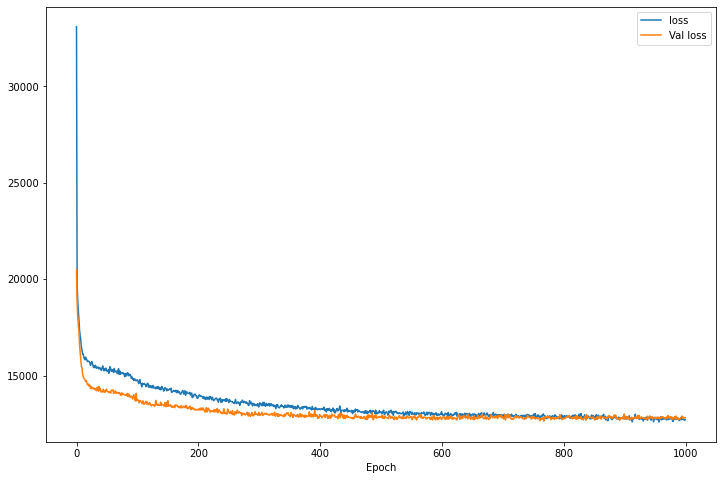

In [38]:
# Plotting the loss
plt.figure(figsize=(12,8))
plt.xlabel('Epoch')
plt.plot(hist['epoch'],hist['loss'], label='loss')
plt.plot(hist['epoch'],hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

# From the below graph, we can see that our training loss and validation loss is gradually decreasing. However, at some point 
# the validation point tend to increase which shows the chances of model being overfitted. Hence, the training of the model is 
# stopped at 1000 epochs.

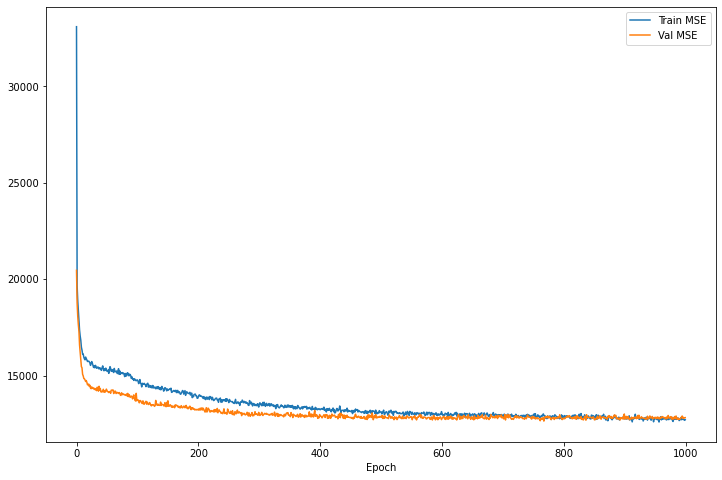

In [71]:
# Plotting the loss
plt.figure(figsize=(12,8))
plt.xlabel('Epoch')
plt.plot(hist['epoch'],hist['mse'], label='Train MSE')
plt.plot(hist['epoch'],hist['val_mse'], label = 'Val MSE')
plt.legend()
plt.show()

# Similar to the above graphs. MSE is also used as an metric to evaluate the model.
# Furthermore, we can try training the model increasing the number of epochs to check if the validation error can be 
# decreased further.

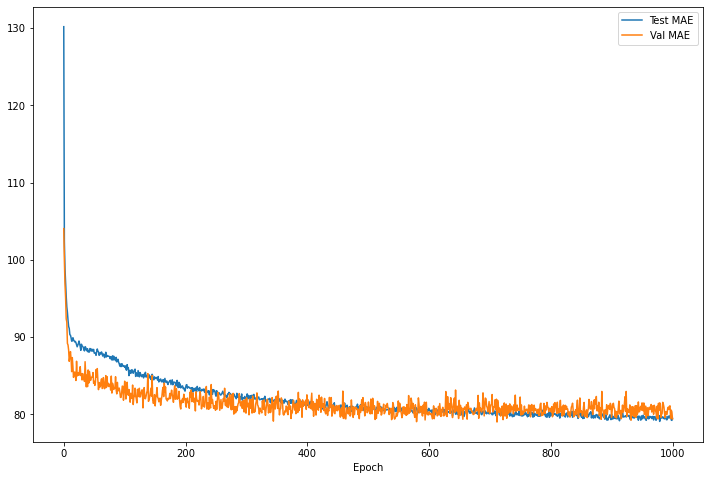

In [72]:
# Plotting the loss
plt.figure(figsize=(12,8))
plt.xlabel('Epoch')
plt.plot(hist['epoch'],hist['mae'], label='Test MAE')
plt.plot(hist['epoch'],hist['val_mae'], label = 'Val MAE')
plt.legend()
plt.show()

In [43]:
# Evaluation on training data
bike_model.evaluate(X_train,y_train)

381/381 [==============================] - 1s 2ms/step - loss: 12271.1895 - mse: 12271.1895 - mae: 77.4537


[12271.189453125, 12271.189453125, 77.45372772216797]

In [44]:
# evaluation on testing data
bike_model.evaluate(X_test,y_test)

163/163 [==============================] - 0s 2ms/step - loss: 12372.4092 - mse: 12372.4092 - mae: 78.1708


[12372.4091796875, 12372.4091796875, 78.17076110839844]

In [56]:
# Predicting the test data on the generated model
predictions = bike_model.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:"Predicted"},inplace=True)

In [53]:
actual = pd.DataFrame(y_test)
actual.rename(columns={0:"Actual"},inplace=True)

In [57]:
# Concatenating the actual and predicted data
results = pd.concat([actual,predictions],axis=1)
results.head(5)

,Actual,Predicted
0,425,408.244385
1,88,148.959381
2,4,40.486961
3,526,498.384155
4,13,24.450012


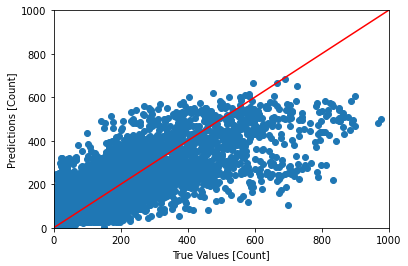

In [66]:
# Plotting the predicted vs actual results
plt.scatter(results['Actual'],results['Predicted'])
plt.xlabel('True Values [Count]')
plt.ylabel('Predictions [Count]')
limits = (0,1000)
plt.xlim(limits)
plt.ylim(limits)
plt.plot(limits,limits,color='red')
# From the below graph we can see that the errors are distributed across and the model performs average in predicting the number
# of vehicles.

<AxesSubplot:xlabel='error', ylabel='Count'>

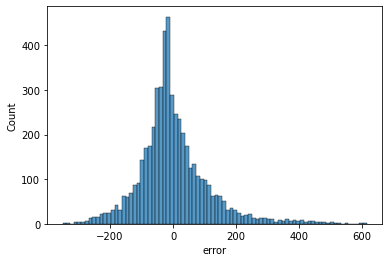

In [70]:
# Plotting the errors
results['error'] = errors = results['Actual'] - results['Predicted']
sns.histplot(data=results,x='error')
# From the below graph we can see that our errors are nearly following gaussian distribution.